# **SLDS Rabinovich Fabrikant 3D 6states**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time as time
import random 
import reservoirpy.datasets as rsvp_d

from scipy.special import logsumexp
from scipy.stats import multivariate_normal, invwishart, matrix_normal

## Data generation

In [2]:
def Plot3D(xs, ys, zs, title, start, pt_number, lw):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(xs[start:start+pt_number], ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    plt.show()
    


def Plot2D(xs, ys, zs, titl1, titl2, titl3, start, pt_number, lw):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15, 5))

    ax1.plot(xs[start:start+pt_number], ys[start:start+pt_number], lw=lw)
    ax1.set_title(titl1)
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")

    ax2.plot(xs[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax2.set_title(titl2)
    ax2.set_xlabel("X Axis")
    ax2.set_ylabel("Z Axis")

    ax3.plot(ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax3.set_title(titl3)
    ax3.set_xlabel("Y Axis")
    ax3.set_ylabel("Z Axis")

    plt.show()

In [3]:
t1 = time.time() #times the computation
arr = rsvp_d.rabinovich_fabrikant(1500, alpha=1.1, gamma=0.89, x0=[- 1, 0, 0.5], h=0.05)
xs = arr[:,0]
ys = arr[:,1]
zs = arr[:,2]
t2 = time.time()
print ('computation takes ',t2-t1,' seconds.')

computation takes  0.031080961227416992  seconds.


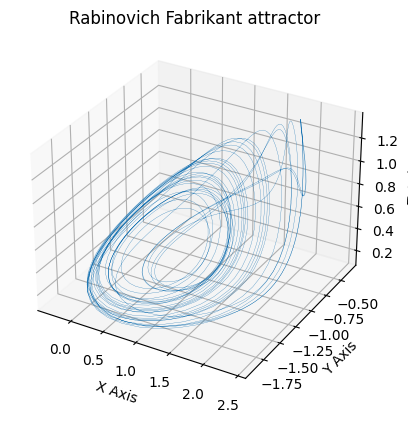

In [4]:
Plot3D(ys, xs, zs, "Rabinovich Fabrikant attractor", start=0, pt_number=2500, lw=0.2)

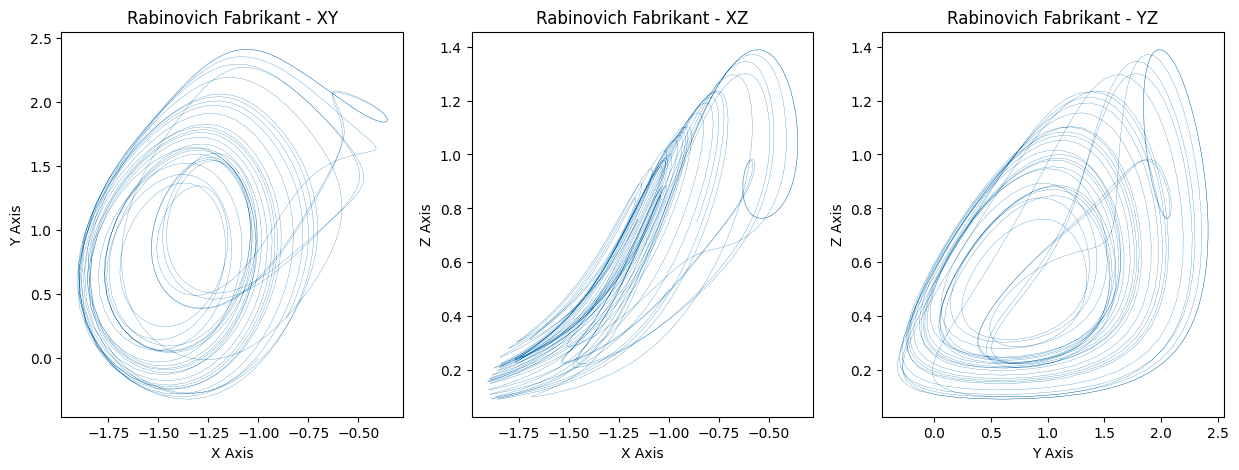

In [5]:
Plot2D(xs, ys, zs, "Rabinovich Fabrikant - XY", "Rabinovich Fabrikant - XZ", "Rabinovich Fabrikant - YZ", start=0, pt_number=2500, lw=0.2)

In [6]:
y = arr[0:1500,0:3].copy()
y[:, 0] = y[:, 0]/1.5 + 1
y[:, 1] = y[:, 1]/1.5 - 0.8
y[:, 2] = y[:, 2]/0.7 - 1
y.shape

(1500, 3)

(-1.0, 1.0)

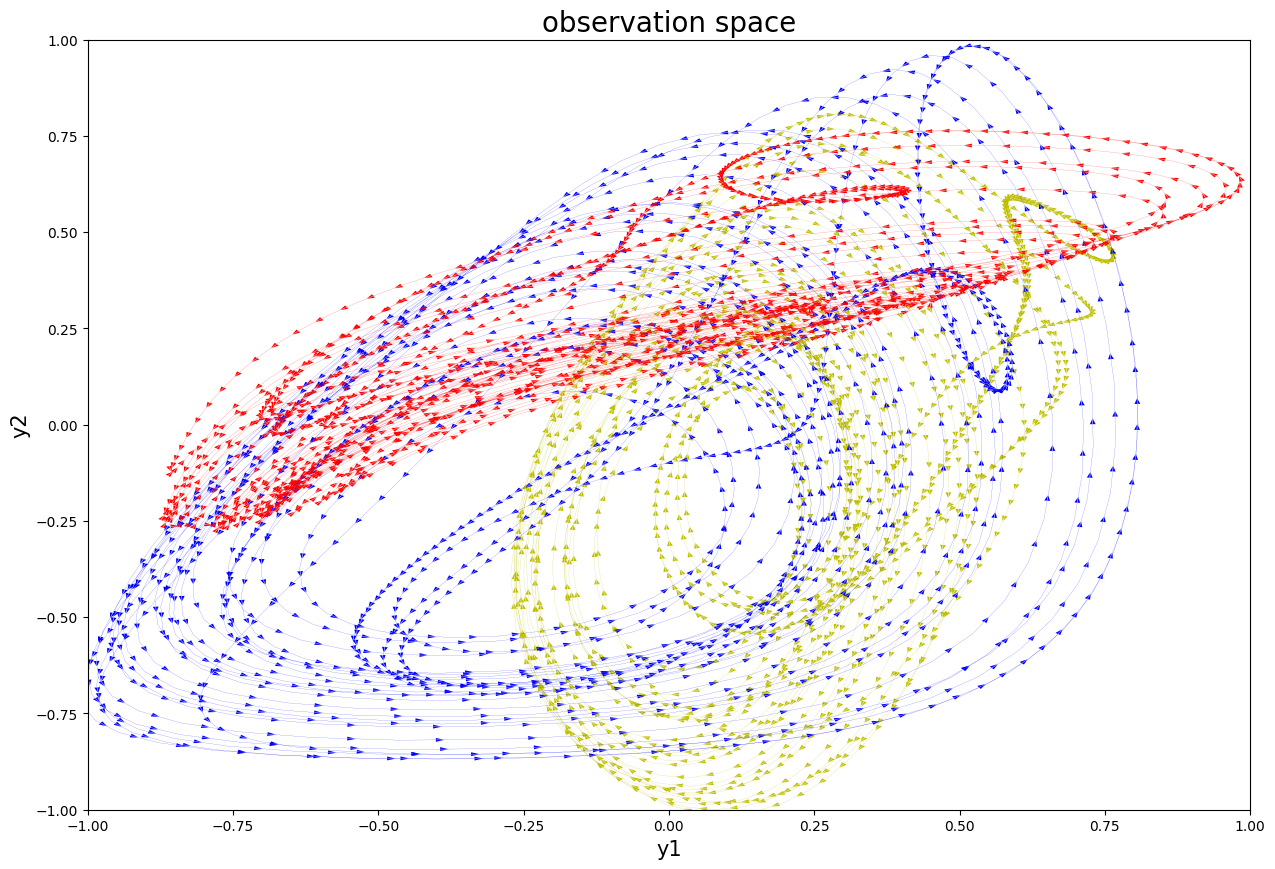

In [7]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1], lw = 0.1, color = "y")
plt.plot(y[:, 1], y[:, 2], lw = 0.1, color = "b")
plt.plot(y[:, 2], y[:, 0], lw = 0.1, color = "r")

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "y")
    
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 1], y[t+1, 1]])
    arr_mean_y2 = np.mean([y[t, 2], y[t+1, 2]])
    dy1 = y[t+1, 1] - y[t, 1]
    dy2 = y[t+1, 2] - y[t, 2]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "b")
    
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 2], y[t+1, 2]])
    arr_mean_y2 = np.mean([y[t, 0], y[t+1, 0]])
    dy1 = y[t+1, 2] - y[t, 2]
    dy2 = y[t+1, 0] - y[t, 0]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "r")
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [8]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [9]:
T = y.shape[0] # number of time steps
N = 3 # observation dim
K = 6 # latent dim

L = 40 # how many Gibbs iteration to do

### PRIORS
# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

S = np.array([1/120, 1/80, 1/100])*np.eye(N, N) # 1 meter in each direction
nu = N
C = 0.1*np.random.randn(N, N+1)
C[:, 0] = np.zeros(N)
C[:, 1:] = np.eye(N, N)
#V = generate_random_semipositive_matrix(N+1, 1) # it should be a semipositive matrix, given what i found
V = 1*np.eye(N+1, N+1)

### INFERRED VARIABLES
# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])
#M_inf[0] = np.copy(M)

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0][:, :, 0] = 1*np.random.randn(K, N)
A_hat_inf[0][:, :, 1:] = 1*np.random.randn(K, N, N)
#A_hat_inf[0] = np.copy(A_hat) + 0.05*np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([np.array([1/120, 1/80, 1/100])*np.eye(N, N) for k in range(K)])# + np.copy(Q)# + 0.06*np.random.randn(K, N, N)

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

print(A_hat_inf[0])

[[[ 0.54435905 -0.21933626  0.35734714 -0.38029519]
  [ 1.51898773  0.87330597  1.62893337  0.07117207]
  [ 1.77086245 -0.29656431 -0.72050382  0.04944807]]

 [[ 0.42035549  0.38734989  1.46462141  0.89675002]
  [ 1.27658149  1.33371243 -2.70753228 -0.9551085 ]
  [ 0.74606391 -0.42530994  0.36828269  0.18872134]]

 [[-0.26130916 -0.83095479 -0.5993352  -1.17652859]
  [ 0.85817322  1.32691464  0.01990883 -0.20707192]
  [ 0.76727645 -0.88492174 -0.44363051 -1.53061695]]

 [[ 0.68987554 -1.31061618 -0.09657614  1.01347817]
  [ 1.37612777  1.66307051  2.02786882 -0.67540299]
  [-0.20233223 -1.06704605  1.03235077 -1.16545555]]

 [[-0.66568001  1.12910736 -0.2161025   1.8941425 ]
  [-0.64149095  0.02799089  1.06458104  0.58795358]
  [ 0.39092727  0.05853129  0.73605873  0.30583292]]

 [[ 0.41795323 -0.80640386  1.37758719 -0.1843485 ]
  [-0.33789266  1.76160185  1.39206881 -1.17899951]
  [ 0.88940788 -0.58659385 -1.54355941  1.87550837]]]


In [10]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

In [11]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):
    m = [np.array([1]*K)]
    log_m = [np.array([0]*K)]

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]
        
        for k in range(K):
            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # list of log messages

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [12]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in range(L-1):
    
    print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)


 SAMPLE: 0

 SAMPLE: 1

 SAMPLE: 2

 SAMPLE: 3

 SAMPLE: 4

 SAMPLE: 5

 SAMPLE: 6

 SAMPLE: 7

 SAMPLE: 8

 SAMPLE: 9

 SAMPLE: 10

 SAMPLE: 11

 SAMPLE: 12

 SAMPLE: 13

 SAMPLE: 14

 SAMPLE: 15

 SAMPLE: 16

 SAMPLE: 17

 SAMPLE: 18

 SAMPLE: 19

 SAMPLE: 20

 SAMPLE: 21

 SAMPLE: 22

 SAMPLE: 23

 SAMPLE: 24

 SAMPLE: 25

 SAMPLE: 26

 SAMPLE: 27

 SAMPLE: 28

 SAMPLE: 29

 SAMPLE: 30

 SAMPLE: 31

 SAMPLE: 32

 SAMPLE: 33

 SAMPLE: 34

 SAMPLE: 35

 SAMPLE: 36

 SAMPLE: 37

 SAMPLE: 38


In [13]:
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[10:], return_counts=True)
print(dict(zip(unique, counts)))

[2 3 1 ... 3 3 2]
[0 4 3 ... 4 4 4]
[3 3 3 ... 4 4 4]
[2.475 3.075 2.95  ... 3.975 3.975 3.95 ]
{0: 4, 1: 2, 2: 3, 3: 12386, 4: 21771, 5: 10834}


In [14]:
print(np.mean(M_inf, axis = 0))
eigw_inf, eigv_inf = np.linalg.eig(np.mean(M_inf, axis = 0).T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0]))

[[0.19547197 0.19852653 0.14104262 0.16766699 0.14874996 0.14854193]
 [0.14701474 0.18414345 0.15064307 0.17040082 0.17237675 0.17542116]
 [0.23341863 0.15677246 0.13988377 0.15602097 0.14999354 0.16391063]
 [0.00827362 0.00354535 0.01485805 0.89566217 0.00320891 0.0744519 ]
 [0.01079962 0.00329832 0.00196035 0.03843062 0.94252258 0.00298852]
 [0.01137625 0.0059131  0.00677995 0.0053734  0.08312864 0.88742866]]
[ 2.46270289e+15 -1.58599126e+15 -1.04440556e+15  1.82703618e+13
  5.80650229e+13  9.13585468e+13]


In [15]:
print(np.mean(A_hat_inf, axis = 0))

[[[ 7.80946385e-02  9.87721424e-01 -2.65495446e-01 -1.31999171e-01]
  [ 1.82707284e-01 -9.00175210e-02  9.12611950e-01  1.94176772e-02]
  [-1.08651470e-02  4.54749647e-02 -6.49866246e-03  1.09891522e+00]]

 [[-1.45722053e-01  7.69806403e-01  2.51465985e-01  3.57955674e-01]
  [-9.84302829e-02 -1.63023052e-01  1.03021747e+00  1.34567005e-01]
  [ 1.47929892e-02 -5.61054932e-02  8.65563838e-02  9.31623227e-01]]

 [[ 1.27238446e+00  6.26262283e-01  1.68426162e+00 -1.20013148e+00]
  [ 1.36836375e+00  8.98392529e-02  3.15854829e+00 -1.05536483e+00]
  [ 2.76341615e+00 -1.10898805e+00  2.48066304e+00 -4.16920616e-01]]

 [[ 2.84719145e-02  9.49646269e-01  6.10443840e-02  2.69309351e-02]
  [ 3.38752201e-02 -1.38854084e-01  1.05529830e+00 -1.12727698e-01]
  [-2.59725291e-02 -5.13458576e-02  1.06839837e-01  8.69986599e-01]]

 [[ 4.67460441e-03  9.37228502e-01  3.16112673e-02  7.16038273e-02]
  [-7.61604132e-02  7.72409916e-02  1.04597707e+00 -3.91441350e-02]
  [ 1.00498282e-01 -2.33111011e-01  1.69

In [16]:
Q_inf_av = np.mean(Q_inf, axis = 0)
for k in range(K):
    print(Q_inf_av[k])
    eigw_q, _ = np.linalg.eig(Q_inf_av[k])
    print(eigw_q)

[[ 0.97138819  0.61604161 -0.0934126 ]
 [ 0.61604161  1.13814582 -0.30038869]
 [-0.0934126  -0.30038869  0.23968695]]
[1.73233269 0.48465668 0.13223159]
[[ 3.45787717  1.39825738 -0.01557433]
 [ 1.39825738  0.94312734  0.04146559]
 [-0.01557433  0.04146559  0.22939253]]
[4.08096024 0.33803919 0.21139761]
[[31.04741727 36.51796253 44.76542447]
 [36.51796253 46.87737046 45.484514  ]
 [44.76542447 45.484514   86.96632756]]
[145.52625013   0.41217664  18.95268852]
[[2.59026041e-04 7.22785283e-06 9.82142613e-06]
 [7.22785283e-06 5.52283386e-04 4.04218904e-05]
 [9.82142613e-06 4.04218904e-05 3.34261319e-04]]
[0.0005598  0.00025775 0.00032802]
[[ 2.53335444e-04 -5.70811539e-06  7.67354795e-05]
 [-5.70811539e-06  4.03621370e-04 -9.17610802e-05]
 [ 7.67354795e-05 -9.17610802e-05  6.06161125e-04]]
[0.00065511 0.00023619 0.00037182]
[[ 3.23584583e-04  2.14012645e-05  2.40728801e-05]
 [ 2.14012645e-05  5.64276634e-04 -1.81365469e-05]
 [ 2.40728801e-05 -1.81365469e-05  4.05461595e-04]]
[0.00031443 

In [17]:
#b_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,0]
#A_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,1:]
b_inf_av = A_hat_inf[-1][:,:,0]
A_inf_av = A_hat_inf[-1][:,:,1:]

In [18]:
# Define the grid of x, y, z points
y = arr[:1500,0:3].copy()
y[:, 0] = y[:, 0]/11 - 0.1
y[:, 1] = y[:, 1]/10 + 0.1
y[:, 2] = y[:, 2]/11 - 1

z = z_inf[-1]
A = A_inf_av
b = b_inf_av
x_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])
U = np.zeros((y.shape[0]))
V = np.zeros((y.shape[0]))
W = np.zeros((y.shape[0]))

# Define the vector field components
for l in range(y.shape[0]):
    k = z[l]
    U[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[0] + b[k, 0] - y[l, 0]
    V[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[1] + b[k, 1] - y[l, 1]
    W[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[2] + b[k, 2] - y[l, 2]

conversion = {0: "b",
              1: "r", 
              2: "y", 
              3: "g", 
              4: "m", 
              5: "c", 
              6: "k", 
              7: "0.2",
              8: "0.5",
              9: "0.8"}

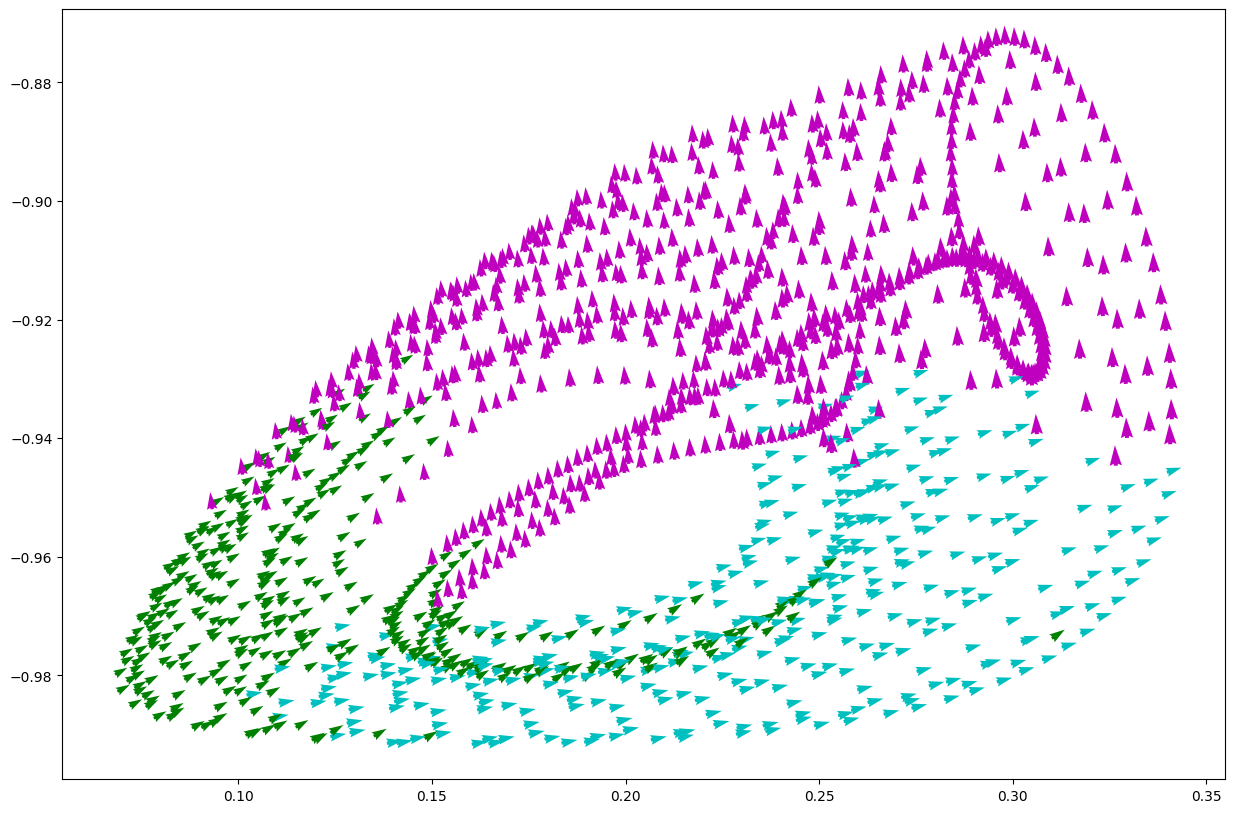

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')

# Plot the 3D vector field
ax.quiver(y[:, 1], y[:, 2], V, W, color = [conversion[i] for i in z], width = 1*1e-2)#, length=0.1, normalize=True, lw = 0.5)
plt.show()

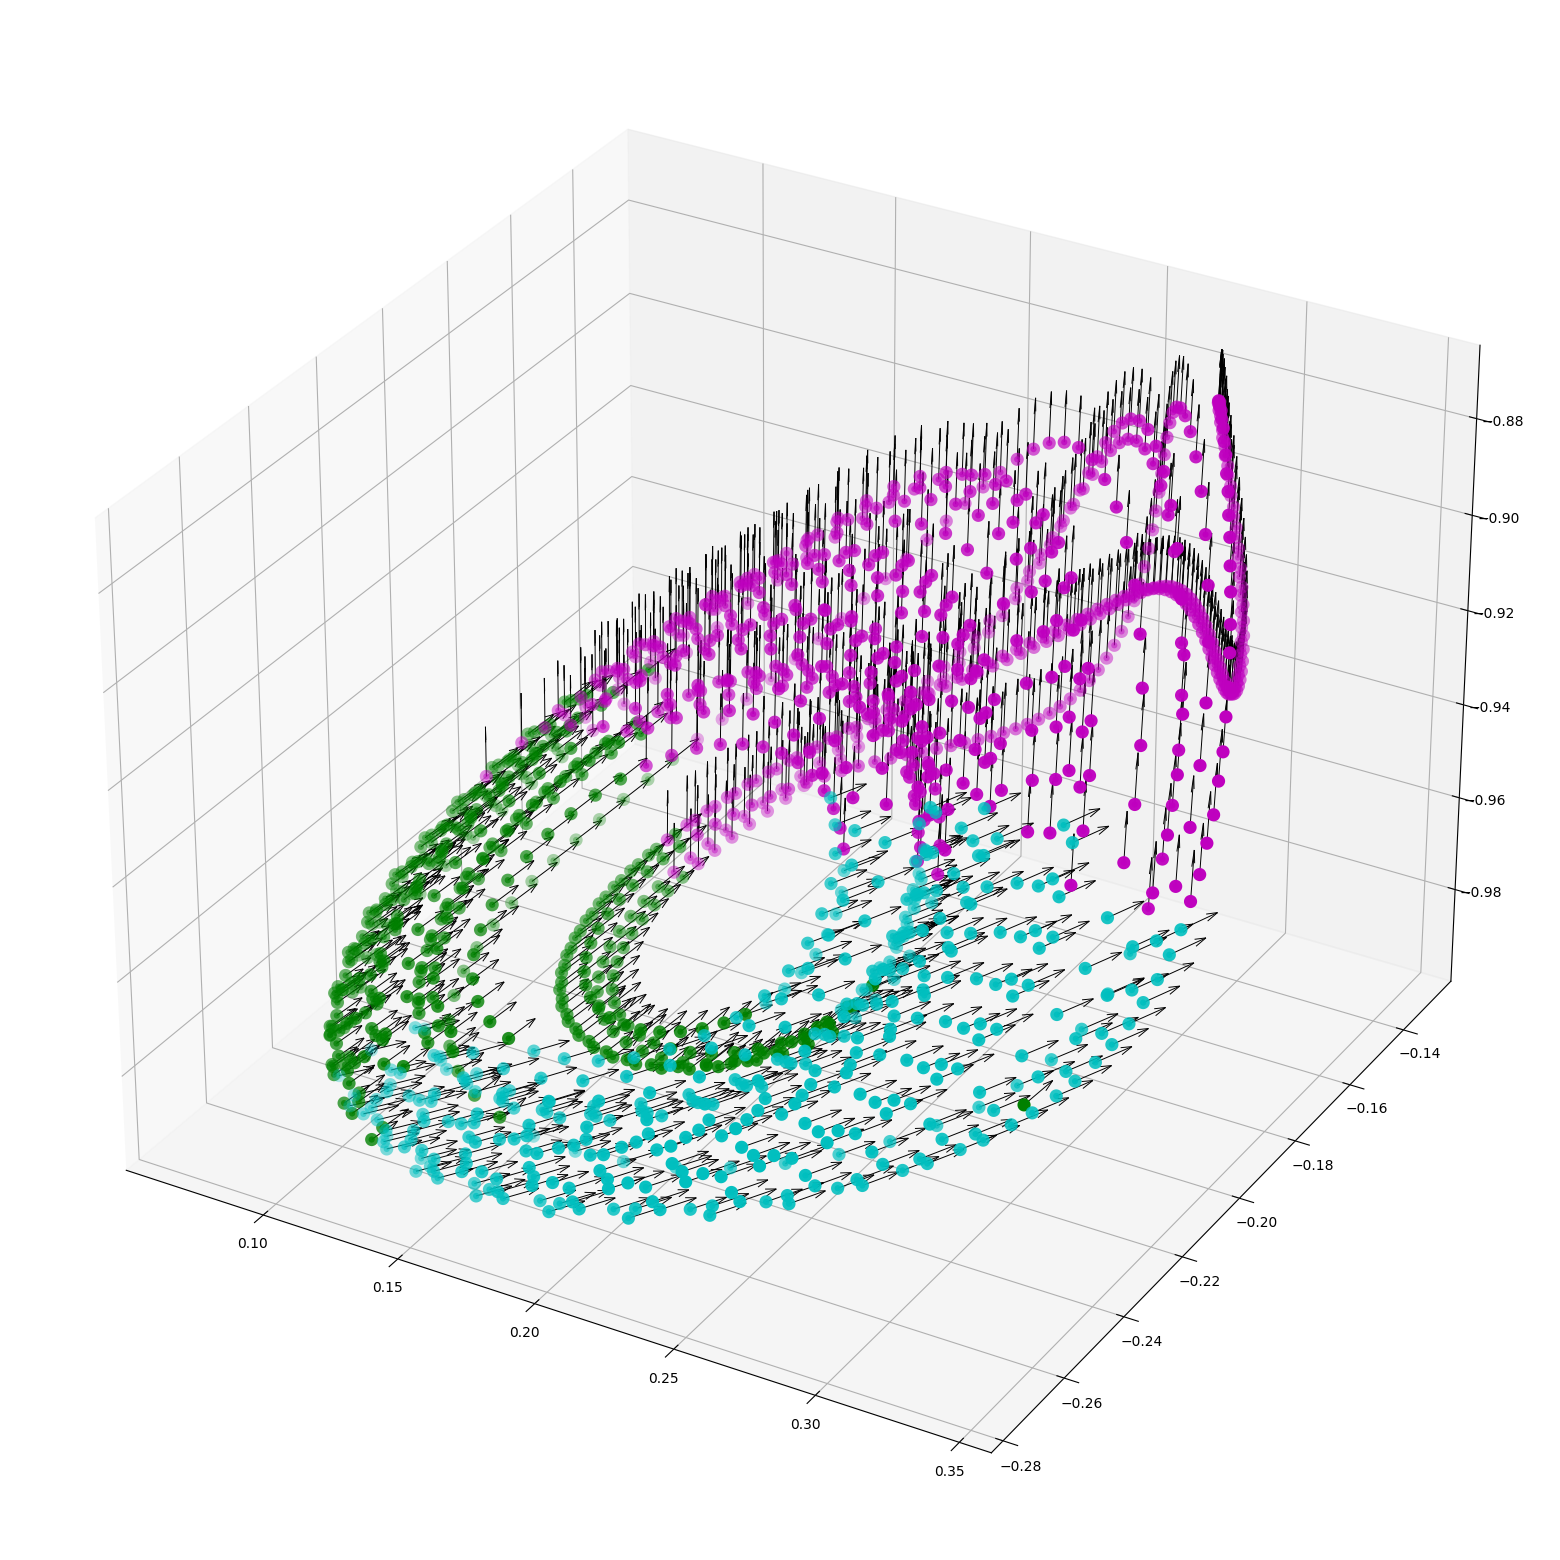

In [20]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D vector field
ax.quiver(y[:, 1], y[:, 0], y[:, 2], V, U, W, length=1e-2, normalize=True, lw = 0.7, color = "k")
for i in range(K):
    ax.scatter(y[:, 1][z == i], y[:, 0][z == i], y[:, 2][z == i], color = conversion[i], lw = 5)
    
plt.show()